In [1]:
%matplotlib inline


DCGAN Tutorial
==============

**Author**: `Nathan Inkawhich <https://github.com/inkawhich>`__




Introduction
------------

This tutorial will give an introduction to DCGANs through an example. We
will train a generative adversarial network (GAN) to generate new
celebrities after showing it pictures of many real celebrities. Most of
the code here is from the dcgan implementation in
`pytorch/examples <https://github.com/pytorch/examples>`__, and this
document will give a thorough explanation of the implementation and shed
light on how and why this model works. But don’t worry, no prior
knowledge of GANs is required, but it may require a first-timer to spend
some time reasoning about what is actually happening under the hood.
Also, for the sake of time it will help to have a GPU, or two. Lets
start from the beginning.

## 前書き
このチュートリアルでは、例を通してDCGANの概要を説明します。私たちはそれに多くの本当の有名人の写真を見せた後に新しい有名人を生成するために生成的な敵対的ネットワーク（GAN）を訓練します。ここのコードの大部分はpytorch / examplesの dcgan実装からの ものです、そしてこのドキュメントは実装の徹底的な説明を与えて、そしてこのモデルがどのようにそしてなぜ働くのかについて解明するでしょう。しかし、心配しないでください、GANについての予備知識は必要ありませんが、実際に何が起こっているのかについて考えるのに時間を費やすにはファーストタイマーが必要な場合があります。また、時間のために、それは1つ、または2つのGPUを持つのを助けるでしょう。初めから始めましょう。

Generative Adversarial Networks
-------------------------------

What is a GAN?
--------------

## 生成的敵対的ネットワーク
### GANとは何ですか？

GANs are a framework for teaching a DL model to capture the training
data’s distribution so we can generate new data from that same
distribution. GANs were invented by Ian Goodfellow in 2014 and first
described in the paper `Generative Adversarial
Nets <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__.
They are made of two distinct models, a *generator* and a
*discriminator*. The job of the generator is to spawn ‘fake’ images that
look like the training images. The job of the discriminator is to look
at an image and output whether or not it is a real training image or a
fake image from the generator. During training, the generator is
constantly trying to outsmart the discriminator by generating better and
better fakes, while the discriminator is working to become a better
detective and correctly classify the real and fake images. The
equilibrium of this game is when the generator is generating perfect
fakes that look as if they came directly from the training data, and the
discriminator is left to always guess at 50% confidence that the
generator output is real or fake.

Now, lets define some notation to be used throughout tutorial starting
with the discriminator. Let $x$ be data representing an image.
$D(x)$ is the discriminator network which outputs the (scalar)
probability that $x$ came from training data rather than the
generator. Here, since we are dealing with images the input to
$D(x)$ is an image of HWC size 3x64x64. Intuitively, $D(x)$
should be HIGH when $x$ comes from training data and LOW when
$x$ comes from the generator. $D(x)$ can also be thought of
as a traditional binary classifier.

For the generator’s notation, let $z$ be a latent space vector
sampled from a standard normal distribution. $G(z)$ represents the
generator function which maps the latent vector $z$ to data-space.
The goal of $G$ is to estimate the distribution that the training
data comes from ($p_{data}$) so it can generate fake samples from
that estimated distribution ($p_g$).

So, $D(G(z))$ is the probability (scalar) that the output of the
generator $G$ is a real image. As described in `Goodfellow’s
paper <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__,
$D$ and $G$ play a minimax game in which $D$ tries to
maximize the probability it correctly classifies reals and fakes
($logD(x)$), and $G$ tries to minimize the probability that
$D$ will predict its outputs are fake ($log(1-D(G(x)))$).
From the paper, the GAN loss function is

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]\end{align}

In theory, the solution to this minimax game is where
$p_g = p_{data}$, and the discriminator guesses randomly if the
inputs are real or fake. However, the convergence theory of GANs is
still being actively researched and in reality models do not always
train to this point.

GANは、トレーニングデータの分布を取得するようにDLモデルを教えるためのフレームワークです。そのため、同じ分布から新しいデータを生成できます。GANは、2014年にIan Goodfellowによって発明され、最初にGenerative Adversarial Netsという論文で説明されました。それらは、2つの異なるモデル、Generator(生成器)とDiscriminator(判別器)で構成されています。。Generator(生成器)の仕事は、トレーニング画像のように見える「偽の」画像を生成することです。Discriminator(判別器)の仕事は、画像を見て、それが実際の訓練用画像であるか偽の画像であるかをGenerator(生成器)から出力することである。訓練中、Generator(生成器)は絶えずより良い偽物を発生させることによってDiscriminator(判別器)を凌駕しようとしているが、Discriminator(判別器)はより良い探偵になりそして本物の画像と偽の画像を正しく分類するように働いている。このゲームの均衡は、Generator(生成器)がトレーニングデータから直接来たかのように見える完璧な偽物を生成しているときであり、Discriminator(判別器)は常にGenerator(生成器)の出力が本物であるか偽物であると50％の確信で推測するために残されます。

それでは、Discriminator(判別器)から始めてチュートリアル全体で使用する表記法を定義しましょう。xは画像を表すデータとします。 D(x) は（スカラ）確率を出力するDiscriminator(判別器)ネットワークです。 ここでのxはGenerator(生成器)ではなくトレーニングデータからのデータです。ここでは、画像を扱っているので、 D(x)はHWCサイズ3x64x64の画像です。直感的にD(x) は、xがトレーニングデータから得られる時はHIGHに、xがGenerator(生成器)から来る時はLOWにする必要があります。 D(x)は伝統的なバイナリ分類器と考えることもできます。

Generator(生成器)の表記について、 zは標準正規分布からサンプリングされた潜在空間ベクトルとします。G(z)は潜在ベクトルzをデータスペースへ写像するGenerator(生成器)関数を表す。Gの目標はトレーニングデータ（Pdata）が由来する分布を推定することで、その推定分布（Pg）から偽のサンプルを生成することができます。

そう、 D(G(z))は確率（スカラ）であり、Generator(生成器)Gの出力は実画像です。Goodfellowの論文に記載されているように、 DとGのミニマックスゲームをプレイする。Dは実物と偽物を正しく分類する確率を最大にしようとします（logD(x)）。Gは、Dがその出力が偽物であると予測する（log(1−D(G(x)))）確率を最小にすることを試みます。論文から、GANの損失関数は

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]\end{align}

理論的には、このミニマックスゲームの解決策は次のとおりです。 Pg=Pdataそして、Discriminator(判別器)は入力が本物か偽物かをランダムに推測する。しかし、GANの収束理論はまだ活発に研究されており、実際にはモデルは常にこの点まで訓練されていません。

What is a DCGAN?
--------------

A DCGAN is a direct extension of the GAN described above, except that it
explicitly uses convolutional and convolutional-transpose layers in the
discriminator and generator, respectively. It was first described by
Radford et. al. in the paper `Unsupervised Representation Learning With
Deep Convolutional Generative Adversarial
Networks <https://arxiv.org/pdf/1511.06434.pdf>`__. The discriminator
is made up of strided
`convolution <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`__
layers, `batch
norm <https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d>`__
layers, and
`LeakyReLU <https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU>`__
activations. The input is a 3x64x64 input image and the output is a
scalar probability that the input is from the real data distribution.
The generator is comprised of
`convolutional-transpose <https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d>`__
layers, batch norm layers, and
`ReLU <https://pytorch.org/docs/stable/nn.html#relu>`__ activations. The
input is a latent vector, $z$, that is drawn from a standard
normal distribution and the output is a 3x64x64 RGB image. The strided
conv-transpose layers allow the latent vector to be transformed into a
volume with the same shape as an image. In the paper, the authors also
give some tips about how to setup the optimizers, how to calculate the
loss functions, and how to initialize the model weights, all of which
will be explained in the coming sections.

### DCGANとは何ですか？
ＤＣＧＡＮは、それがGenerator(生成器)およびDiscriminator(判別器)においてそれぞれ明示的に畳み込み層および畳み込み - 転置層を明示的に使用することを除いて、上記のＧＡＮの直接拡張である。それはRadford等によって最初に記述されました。論文でディープ畳み込みジェネレーティブ敵対ネットワークと教師なしの表現を学びます。Discriminator(判別器)はストライドで構成されて 畳み込み 層、バッチノルム 層、および LeakyReLUの アクティベーション。入力は3 x 64 x 64の入力画像で、出力は入力が実際のデータ分布からのものであるというスカラ確率です。Generator(生成器)は、 畳み込み - 転置 レイヤ、バッチノルムレイヤ、および ReLUで構成されています。アクティベーション 入力は潜在ベクトルです。zこれは標準正規分布から作成されたもので、出力は3 x 64 x 64のRGB画像です。ストライド逆転置層は、潜ベクトルを画像と同じ形状を有するボリュームに変換することを可能にする。この論文では、著者はオプティマイザの設定方法、損失関数の計算方法、モデルの重み付けの初期化方法についてもいくつかのヒントを提供します。これらのすべてについては、次のセクションで説明します。

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
import time

Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




## 入力
実行のためにいくつかの入力を定義しましょう：

- dataroot - データセットフォルダのルートへのパス。次のセクションでデータセットについてもっと話します。
- workers - DataLoaderでデータをロードするためのワーカースレッドの数
- batch_size - トレーニングで使用されるバッチサイズ DCGAN用紙は128のバッチサイズを使用します
- image_size - トレーニングに使用される画像の空間サイズ この実装はデフォルトで64x64になります。別のサイズが必要な場合は、DとGの構造を変更する必要があります。参照してください ここに詳細
- nc - 入力画像のカラーチャンネル数 カラー画像の場合、これは3です。
- nz - 潜在ベクトルの長さ
- ngf - Generator(生成器)を通して運ばれる機能マップの深さに関連します
- ndf - Discriminator(判別器)を介して伝達される特徴マップの深さを設定します
- num_epochs - 実行するトレーニング期間の数。長期間のトレーニングはおそらくより良い結果につながるでしょうが、またはるかに長い時間がかかるでしょう
- lr - トレーニングの学習率 DCGANの論文に記載されているように、この数は0.0002になります。
- Adamオプティマイザ用のbeta1 - beta1ハイパーパラメータ。紙で説明されているように、この数は0.5であるはずです
- ngpu - 利用可能なGPUの数 これが0の場合、コードはCPUモードで実行されます。この数が0より大きい場合は、その数のGPUで実行されます。

In [6]:
# Root directory for dataset
#dataroot = ""data/celeba"
dataroot = "E:/Data/ffhq-dataset/thumbnails128x128/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Data
----

In this tutorial we will use the `Celeb-A Faces
dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`__ which can
be downloaded at the linked site, or in `Google
Drive <https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg>`__.
The dataset will download as a file named *img_align_celeba.zip*. Once
downloaded, create a directory named *celeba* and extract the zip file
into that directory. Then, set the *dataroot* input for this notebook to
the *celeba* directory you just created. The resulting directory
structure should be:

## データ
このチュートリアルでは、リンク先のサイトまたはGoogleドライブでダウンロードできるCeleb-A Facesデータセットを使用します。データセットはimg_align_celeba.zipという名前のファイルとしてダウンロードされます。ダウンロードしたら、celebaという名前のディレクトリを作成し、そのディレクトリにzipファイルを抽出します。次に、このノートブックのdataroot入力を先ほど作成したcelebaディレクトリに設定します。結果のディレクトリ構造は次のようになります。

```
   /path/to/celeba
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
              ...
```

This is an important step because we will be using the ImageFolder
dataset class, which requires there to be subdirectories in the
dataset’s root folder. Now, we can create the dataset, create the
dataloader, set the device to run on, and finally visualize some of the
training data.

ImageFolderデータセットクラスを使用するので、これは重要な手順です。このクラスでは、データセットのルートフォルダにサブディレクトリが必要です。これで、データセットを作成し、データローダーを作成し、デバイスを実行するように設定して、最後にトレーニングデータの一部を視覚化できます。

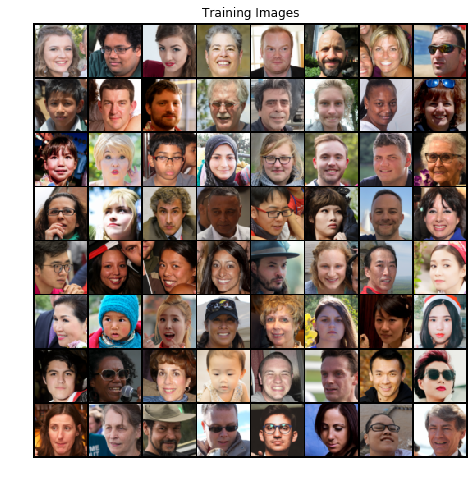

In [7]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
dataset

Dataset ImageFolder
    Number of datapoints: 70000
    Root Location: E:/Data/ffhq-dataset/thumbnails128x128/
    Transforms (if any): Compose(
                             Resize(size=64, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(64, 64))
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [9]:
dataloader

In [10]:
device

device(type='cuda', index=0)

In [11]:
type(real_batch)

list

In [12]:
len(real_batch)

2

In [13]:
len(real_batch[0])

128

In [14]:
np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)).shape

torch.Size([530, 530, 3])

In [15]:
vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7608,  ..., 0.8157, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.9961,  ..., 0.9098, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7765,  ..., 0.2745, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.7961,  ..., 0.9804, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7137,  ..., 0.2353, 0.0000, 0.

In [16]:
real_batch[0].to(device)[:64].shape

torch.Size([64, 3, 64, 64])

Implementation
--------------

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weigth initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.

## 実装
入力パラメータを設定し、データセットを準備したら、実装に入ります。ウエイト初期化戦略から始めて、次に、Generator(生成器)、Discriminator(判別器)、損失関数、およびトレーニングループについて詳しく説明します。

Weight Initialization
--------------

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.2. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.

### ウェイト初期化
DCGANの論文から、著者らはすべてのモデルの重みがmean = 0、stdev = 0.2の正規分布からランダムに初期化されることを指定しています。このweights_init関数は、初期化されたモデルを入力として受け取り、この基準を満たすようにすべての畳み込み、畳み込み - 転置、およびバッチ正規化レイヤを再初期化します。この機能は初期化直後にモデルに適用されます。

In [17]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator
--------------

The generator, $G$, is designed to map the latent space vector
($z$) to data-space. Since our data are images, converting
$z$ to data-space means ultimately creating a RGB image with the
same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional
transpose layers, each paired with a 2d batch norm layer and a relu
activation. The output of the generator is fed through a tanh function
to return it to the input data range of $[-1,1]$. It is worth
noting the existence of the batch norm functions after the
conv-transpose layers, as this is a critical contribution of the DCGAN
paper. These layers help with the flow of gradients during training. An
image of the generator from the DCGAN paper is shown below.

### Generator(生成器)
ジェネレータ Gは、潜在空間ベクトル（z）データスペースに。私たちのデータは画像なので、変換する zデータ空間とは、最終的にトレーニング画像と同じサイズのRGB画像を作成することを意味します（3 x 64 x 64）。実際には、これは一連の二次元畳み込み転置層を介して達成され、各二次元畳み込み転置層は２ｄバッチノルム層およびｒｅｌｌ活性化と対になっている。Generator(生成器)の出力は、それをの入力データ範囲に戻すためにtanh関数を通して供給されます。[−1,1]。これはDCGANの論文の重要な貢献であるため、逆転置層の後にバッチノルム関数が存在することに注目する価値があります。これらのレイヤーはトレーニング中のグラデーションの流れを助けます。DCGAN論文からのGenerator(生成器)の画像を以下に示します。

![dcgan_generator](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Notice, the how the inputs we set in the input section (*nz*, *ngf*, and
*nc*) influence the generator architecture in code. *nz* is the length
of the z input vector, *ngf* relates to the size of the feature maps
that are propagated through the generator, and *nc* is the number of
channels in the output image (set to 3 for RGB images). Below is the
code for the generator.

入力セクションで設定した入力（nz、ngf、および nc）がコード内のGenerator(生成器)アーキテクチャにどのように影響するかに注意してください。nzはz入力ベクトルの長さ、ngfはGenerator(生成器)を介して伝播されるフィーチャマップのサイズ、ncは出力画像内のチャネル数です（RGB画像の場合は3に設定されます）。下記はGenerator(生成器)のコードです。

In [18]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




これで、Generator(生成器)をインスタンス化してweights_init 関数を適用することができます。印刷モデルをチェックして、Generator(生成器)オブジェクトがどのように構成されているかを確認します。

In [19]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator
--------------

As mentioned, the discriminator, $D$, is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, $D$ takes
a 3x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and LeakyReLU layers, and outputs the final probability
through a Sigmoid activation function. This architecture can be extended
with more layers if necessary for the problem, but there is significance
to the use of the strided convolution, BatchNorm, and LeakyReLUs. The
DCGAN paper mentions it is a good practice to use strided convolution
rather than pooling to downsample because it lets the network learn its
own pooling function. Also batch norm and leaky relu functions promote
healthy gradient flow which is critical for the learning process of both
$G$ and $D$.




### Discriminator(判別器)
前述のように、Discriminator(判別器) Dは、入力として画像を取り、入力画像が（偽物とは対照的に）本物であるというスカラ確率を出力するバイナリ分類ネットワークです。ここに、D3 x 64 x 64の入力画像を取得し、それを一連のConv2d、BatchNorm2d、およびLeakyReLUの各レイヤーで処理して、Sigmoidアクティベーション関数で最終確率を出力します。このアーキテクチャは、問題に必要な場合はさらに多くのレイヤで拡張できますが、ストライドコンボリューション、BatchNorm、およびLeakyReLUsを使用することには意味があります。DCGANの論文では、ダウンサンプリングするためにプーリングするよりもストライド畳み込みを使用することをお勧めします。ネットワークで独自のプーリング機能を学習できるためです。また、バッチノルムとリーキーレリュ関数は、両方の学習プロセスにとって重要な健全な勾配流を促進します。 G そして D。

Discriminator Code



Discriminator(判別器)コード

In [20]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




これで、Generator(生成器)と同様に、Discriminator(判別器)を作成し、weights_init関数を適用し、モデルの構造を印刷することができます 。

In [21]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss Functions and Optimizers
--------------

With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
(`BCELoss <https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss>`__)
function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.




### 損失関数とオプティマイザ
あり D そして Gセットアップ、我々は彼らが損失関数とオプティマイザを通して学ぶ方法を指定することができます。PyTorchで次のように定義されているバイナリクロスエントロピー損失（BCELoss）関数を使用します。

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

この関数が目的関数の両方の対数成分の計算をどのように提供するかに注意してください（すなわち、 log(D(x)) そして log(1−D(G(z)))）BCE方程式のどの部分を使用するかを指定できます。y入力。これは、間もなく開始されるトレーニングループで実行されますが、どのコンポーネントを計算したいのかを変更することによってどのように選択できるかを理解することが重要です。y （すなわちGTラベル）。

次に、実際のラベルを1、偽のラベルを0と定義します。これらのラベルは、の損失を計算するときに使用されます。 D そして Gこれは元のGAN論文で使用されている規則でもあります。最後に、2つのオプティマイザを設定しました。D そしてひとつの G。DCGANの論文で指定されているように、どちらもAdamオプティマイザで、学習率は0.0002、Beta1 = 0.5です。Generator(生成器)の学習過程を追跡するために、ガウス分布から描かれた潜在的なベクトルの固定バッチ（すなわちfixed_noise）を生成します。トレーニングループでは、このfixed_noiseを定期的にに入力します。Gそして繰り返しを重ねると、ノイズから画像が形成されます。

In [22]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training
--------------

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in `ganhacks <https://github.com/soumith/ganhacks>`__.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.


### トレーニング
最後に、GANフレームワークのすべての部分が定義されたので、それをトレーニングできます。誤ったハイパーパラメーター設定はモードの崩壊を招き、何が悪いのかについての説明がほとんどないため、GANのトレーニングはやや芸術的なものであることに注意してください。ここでは、Ganhacksに示されているベストプラクティスのいくつかを遵守しながら、Goodfellowの論文からのアルゴリズム1に厳密に従います。つまり、「本物と偽物の異なるミニバッチを作成」し、Gの目的関数を調整して最大化します。 logD(G(z))。トレーニングは2つの主要部分に分けられます。パート1ではDiscriminator(判別器)が更新され、パート2ではGenerator(生成器)が更新されます。

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

#### パート1 - Discriminator(判別器)を訓練する

Discriminator(判別器)をトレーニングする目的は、与えられた入力を実際のものまたは偽物として正しく分類する確率を最大にすることです。グッドフェローに関しては、「確率的勾配を上昇させることによってDiscriminator(判別器)を更新する」ことを望みます。実際には、最大化したい log(D(x))+log(1−D(G(z)))。ガーンハックとは別にミニバッチ提案があるため、これを2つのステップで計算します。まず、トレーニングセットから実際のサンプルのバッチを作成し、順方向にパススルーします。D損失を計算します（log(D(x))その後、逆方向パスで勾配を計算します。次に、現在のGenerator(生成器)を使用して偽のサンプルのバッチを作成し、このバッチを先に渡します。D損失を計算します（log(1−D(G(z)))そして、逆方向パスでグラデーションを累積します。さて、すべて本物と偽物の両方のバッチからグラデーションが蓄積されたので、Discriminator(判別器)のオプティマイザのステップを呼び出します。

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

#### パート2 - Generator(生成器)を訓練する

元の論文で述べたように、最小化することでGenerator(生成器)を訓練したいです。 log(1−D(G(z)))より良い偽物を生み出すために。すでに述べたように、これはグッドフェローが、特に学習プロセスの初期段階では、十分な勾配を与えていないことを示しています。解決策として、代わりに最大化したいと思います。log(D(G(z)))。コードでは、Part 1のGenerator(生成器)出力をDiscriminator(判別器)で分類し、実際のラベルをGTとして使用して Gの損失を計算し、Gの勾配を逆方向パスで計算し、最後にGのパラメータをオプティマイザステップで更新します。本物のラベルを損失関数のGTラベルとして使うのは直観的ではないように思えるかもしれませんが、これは私たちがを使うことを可能にします log(x) BCELossの一部ではなく（ log(1−x) これはまさに私たちが望むものです。

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.

最後に、統計レポートを作成し、各エポックの終わりにGのトレーニングの進行状況を視覚的に追跡するためにfixed_noiseバッチをGenerator(生成器)にプッシュします。報告されたトレーニング統計は次のとおりです。

- Loss_D - すべての本物のバッチとすべての偽のバッチの損失の合計として計算されたDiscriminator(判別器)の損失（log(D(x))+log(D(G(z)))）
- Loss_G - Generator(生成器)損失log(D(G(z)))
- Ｄ（ｘ） - 全実バッチに対するDiscriminator(判別器)の（バッチ全体にわたる）平均出力。これは1に近づき始め、Gが良くなると理論的には0.5に収束します。これがなぜなのか考えてください。
- D（G（z）） - すべての偽のバッチに対する平均Discriminator(判別器)出力。最初の数字はDが更新される前で、2番目の数字はDが更新された後です。Gが良くなるにつれて、これらの数は0から始まり、0.5に収束するはずです。これがなぜなのか考えてください。

注：実行するエポックの数やデータセットからデータを削除したかどうかによっては、この手順にはしばらく時間がかかります。

In [23]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
since = time.time()

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\t%.2fs'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, time.time()-since))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Starting Training Loop...
[0/5][0/547]	Loss_D: 1.5218	Loss_G: 6.0581	D(x): 0.6524	D(G(z)): 0.5771 / 0.0040	7.87s
[0/5][50/547]	Loss_D: 0.0520	Loss_G: 32.8903	D(x): 0.9602	D(G(z)): 0.0000 / 0.0000	77.65s
[0/5][100/547]	Loss_D: 0.3057	Loss_G: 8.4383	D(x): 0.8804	D(G(z)): 0.0457 / 0.0018	146.91s
[0/5][150/547]	Loss_D: 0.5537	Loss_G: 10.9933	D(x): 0.9106	D(G(z)): 0.2926 / 0.0000	209.83s
[0/5][200/547]	Loss_D: 2.0857	Loss_G: 8.4517	D(x): 0.3130	D(G(z)): 0.0004 / 0.0008	266.71s
[0/5][250/547]	Loss_D: 0.4092	Loss_G: 5.4559	D(x): 0.7792	D(G(z)): 0.0411 / 0.0073	322.62s
[0/5][300/547]	Loss_D: 0.5920	Loss_G: 3.2922	D(x): 0.7064	D(G(z)): 0.1345 / 0.0546	374.60s
[0/5][350/547]	Loss_D: 0.7413	Loss_G: 2.9327	D(x): 0.6196	D(G(z)): 0.0529 / 0.0905	423.92s
[0/5][400/547]	Loss_D: 0.2497	Loss_G: 5.3411	D(x): 0.8792	D(G(z)): 0.0809 / 0.0138	469.44s
[0/5][450/547]	Loss_D: 0.5616	Loss_G: 5.8861	D(x): 0.9020	D(G(z)): 0.3059 / 0.0056	511.50s
[0/5][500/547]	Loss_D: 1.1215	Loss_G: 4.4439	D(x): 0.5085	D(G(z)): 0

In [24]:
202599/batch_size

1582.8046875

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




## 結果
最後に、私たちがどのようにしたかをチェックしましょう。ここでは、3つの異なる結果を見ます。まず、トレーニング中にDとGの損失がどのように変化したかを確認します。次に、エポックごとにGの出力をfixed_noiseバッチに視覚化します。そして3番目に、Gからの偽のデータのバッチの隣に実際のデータのバッチを見ます。

**損失対トレーニングの反復**

以下は、D＆Gの損失とトレーニングの反復の関係を示したものです。

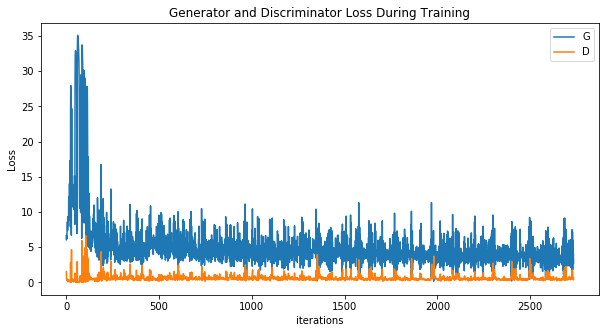

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




#### Gの進行の可視化

トレーニングの各エポックの後に、Generator(生成器)の出力をfixed_noiseバッチにどのように保存したかを覚えておいてください。これで、Gのトレーニング進行をアニメーションで視覚化できます。再生ボタンを押してアニメーションを開始します。

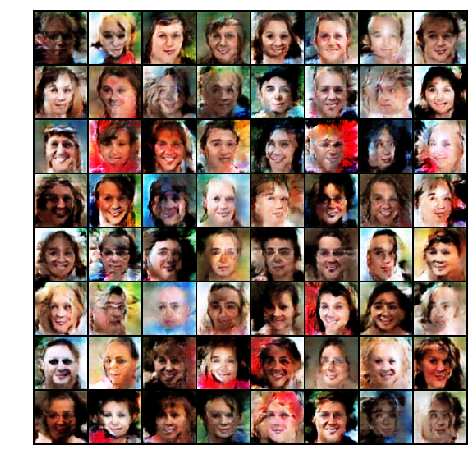

In [26]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




#### 実画像と偽画像

最後に、実際の画像と偽の画像を並べて見てみましょう。

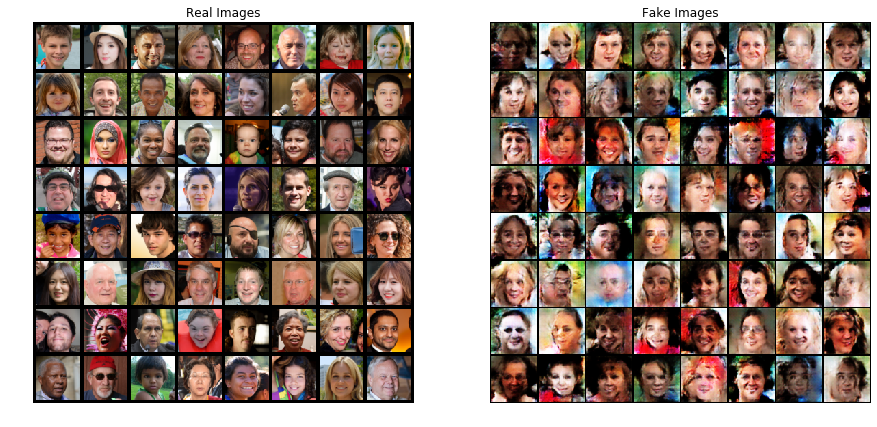

In [27]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Where to Go Next
----------------

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here <https://github.com/nashory/gans-awesome-applications>`__
-  Create GANs that generate
   `music <https://deepmind.com/blog/wavenet-generative-model-raw-audio/>`__




### 次に進む場所
私たちは旅の終わりを迎えましたが、あなたはここから行くことができるいくつかの場所があります。あなたは出来る：

- 結果がどれだけ良いものになるかを見るためにもっと長い間訓練
- このモデルを変更して別のデータセットを取得し、場合によっては画像のサイズとモデルアーキテクチャを変更します。
- ここで他のクールなGANプロジェクトをチェックしてください。
- 音楽を生み出すGANを作成する